<a href="https://colab.research.google.com/github/Thabet-Chaaouri/Diffusers/blob/main/training_and_finetuning_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==10.0

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Dataset

In [ ]:
from datasets import load_dataset

dataset =load_dataset("huggan/smithsonian_butterflies_subset", split="train")

#dataset =load_dataset("huggan/anime-faces", split="train[0%:10%]",num_proc=8)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [ ]:
import torchvision
from torchvision import transforms

image_size= 32
batch_size = 64

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transforms(examples):
  images = [preprocess(image.convert("RGB")) for image in examples["image"]]
  return {"images": images}

dataset.set_transform(transforms)

In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import torch

device = torch.device("cuda")

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

In [ ]:
batch=next(iter(train_dataloader))
batch["images"].shape

torch.Size([64, 3, 32, 32])

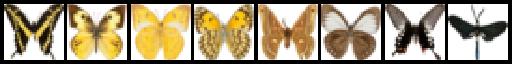

In [ ]:
xb=batch["images"].to(device)[:8]
show_images(xb).resize((8*64,64), resample=Image.NEAREST)

## Define scheduler

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

In [ ]:
timesteps=torch.linspace(0, 999, 8).long().to(device)
noise=torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)

In [ ]:
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

Noisy X shape torch.Size([8, 3, 32, 32])


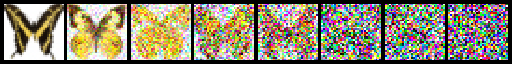

In [ ]:
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

## Define the model

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)

In [ ]:
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Con

## Training loop : training from scratch

In [ ]:
import torch.nn.functional as F

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses =[]

for epoch in range(10):
  for step, batch in enumerate(train_dataloader):
    #add noise
    clean_images=batch["images"].to(device)
    noise = torch.randn_like(clean_images).to(clean_images.device)
    bs = clean_images.shape[0]
    timesteps = torch.randint(0,noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
    noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
    
    #predict noise
    noise_predict = model(noisy_images, timesteps, return_dict=False)[0]

    #loss
    loss = F.mse_loss(noise_predict, noise)
    loss.backward(loss)
    losses.append(loss.item())

    #update model params
    optimizer.step()
    optimizer.zero_grad()
  
  if (epoch+1) % 2 == 0:
    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:2, loss: 0.20831148605793715
Epoch:4, loss: 0.1566938771866262
Epoch:6, loss: 0.14054330065846443
Epoch:8, loss: 0.12563449330627918
Epoch:10, loss: 0.12573262630030513


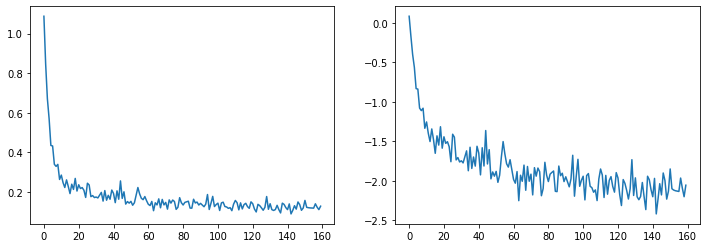

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Generate images

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

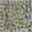

In [ ]:
pipeline_output = image_pipe()
pipeline_output.images[0]

## Accelerate generation with DDIM

In [ ]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

  0%|          | 0/40 [00:00<?, ?it/s]

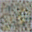

In [ ]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

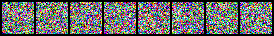

In [ ]:
sample = torch.randn(8,3,32,32).to(device)

show_images(sample)

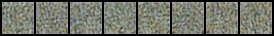

In [ ]:
for i, t in enumerate(scheduler.timesteps):
  with torch.no_grad():
    residual = model(sample, t).sample
  
  sample = scheduler.step(residual, t, sample).prev_sample

show_images(sample)

## Fine tuning diffuser model

In [ ]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: thabet-chaawri. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project="Diffusion_test", config={"learning_rate": 1e-5,
    "architecture": "ddpm-celebahq-256",
    "dataset": "butterflies",
    "epochs": 2,})

In [ ]:
from diffusers import DDPMPipeline
import torch

image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
device = torch.device("cuda")
image_pipe.to(device);

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Get a scheduler for sampling
from diffusers import DDIMScheduler
sampling_scheduler = DDIMScheduler.from_config("google/ddpm-celebahq-256")
sampling_scheduler.set_timesteps(num_inference_steps=50)

In [ ]:
import torchvision
from torchvision import transforms
import torch
from datasets import load_dataset

dataset =load_dataset("huggan/smithsonian_butterflies_subset", split="train")

image_size= 256
batch_size = 4

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transforms(examples):
  images = [preprocess(image.convert("RGB")) for image in examples["image"]]
  return {"images": images}

dataset.set_transform(transforms)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import torch.nn.functional as F
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

lr = 1e-5
num_epochs= 2
grad_accumulation_steps = 3
log_samples_every = 250
save_model_every = 2500

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

losses =[]

for epoch in range(num_epochs):
  for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    #add noise
    clean_images=batch["images"].to(device)
    noise = torch.randn_like(clean_images).to(clean_images.device)
    bs = clean_images.shape[0]
    timesteps = torch.randint(0,image_pipe.scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
    noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)
    
    #predict noise
    noise_predict = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

    #loss
    loss = F.mse_loss(noise_predict, noise)
    wandb.log({'loss':loss.item()})
    loss.backward(loss)
    losses.append(loss.item())

    #update model params
    if (step + 1) % grad_accumulation_steps == 0:
      optimizer.step()
      optimizer.zero_grad()
    
    #occasionally_log_samples
    if (step+1)%log_samples_every == 0:
      x = torch.randn(8, 3, 256, 256).to(device) # Batch of 8
      for i, t in tqdm(enumerate(sampling_scheduler.timesteps)):
        model_input = sampling_scheduler.scale_model_input(x, t)
        with torch.no_grad():
          noise_pred = image_pipe.unet(model_input, t)["sample"]
        x = sampling_scheduler.step(noise_pred, t, x).prev_sample
        grid = torchvision.utils.make_grid(x, nrow=4)
        im = grid.permute(1, 2, 0).cpu().clip(-1, 1)*0.5 + 0.5
        im = Image.fromarray(np.array(im*255).astype(np.uint8))
        wandb.log({'Sample generations': wandb.Image(im)})
      
  scheduler.step()
  print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}"
    )

  0%|          | 0/250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 0 average loss: 0.011175711035786661


  0%|          | 0/250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1 average loss: 0.012784815263643395


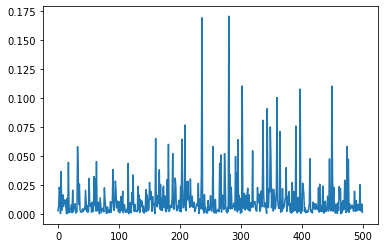

In [ ]:
from matplotlib import pyplot as plt

plt.plot(losses)

In [ ]:
wandb.finish()

loss,▁▂▂▂▂▁▂▂▁▂▂▃▁▁▁▂▂▃▁▃▂▂▂▁▂▁▂▃▁▁▂▅█▂▂▂▁▁▃▂
loss,0.01271
